## Case Study Presentation 
### Subject           - Deep Learning
### Presented by - Ramya Mercy Rajan
### Roll number   - AA.SC.P2MCA2107434

### <span style='font-family:Georgia'> To train the deep learning model, I have used DermaMNIST by MedMNIST; this dataset contains multi-class images of skin lesions taken by dermatoscopy from real-life patients. It has 10000 images with seven classes that could be divided into malignant (Benign keratosis-like lesions, Dermatofibroma, Melanocytic nevi, Vascular lesions) and benign groups(Actinic keratoses and intraepithelial carcinoma, Basal cell carcinoma, Melanoma).

### <span style='font-family:Georgia'> This is a dataset containing multiclass images as (28 x 28) (2D) numpy arrays in the form of an npz file. The images in the dataset have been collected from real life patients via dermascope. The dataset was downloaded from the official website: Available at
#### <https://medmnist.com/>

### <span style='font-family:Georgia'> It is a vast dataset of 10,015 pictures of skin lesions which can be used to identify early stages of skin cancer by  classifying them as malignant or benign. This data set is divided into training, validation and testing dataset; 7007,  1003 and 2005 pictures respectively. I will be building a deep learning neural network which will process an  image and give a prediction output.
### <span style='font-family:Georgia'> Malignant means Cancerous and Benign means Non Cancerous.

![picture](https://drive.google.com/uc?export=view&id=130wWt8lQrPo6wtzndZwr2ZPOquiyXZTA)

In [1]:
#importing all necessary libraries
import numpy as np
import pandas as pd
from numpy import load
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from keras.layers import BatchNormalization
import keras
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
! pip install -q focal-loss
! pip install -q streamlit
! pip install -q pyngrok

     |████████████████████████████████| 9.2 MB 29.0 MB/s 
     |████████████████████████████████| 4.7 MB 59.6 MB/s 
     |████████████████████████████████| 164 kB 73.5 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 182 kB 75.6 MB/s 
     |████████████████████████████████| 237 kB 34.5 MB/s 
     |████████████████████████████████| 62 kB 986 kB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 761 kB 19.2 MB/s 


In [3]:
from focal_loss import SparseCategoricalFocalLoss

### <span style='font-family:Georgia'> Loading the Dataset

In [4]:
#mount google drive to import dataset stored in the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = load('/content/drive/MyDrive/dermamnist.npz')
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


### <span style='font-family:Georgia'> Dataset is split up into training, validation and testing sets respectively for X and Y
### <span style='font-family:Georgia'> The dataset was split into 70% ,10% and 20% for training validation and testing.

In [6]:

X_train, y_train = data['train_images'], data['train_labels']
X_val, y_val = data['val_images'], data['val_labels']
X_test, y_test = data['test_images'], data['test_labels']

print("Train dataset:        ", X_train.shape, y_train.shape)
print("Validation dataset:   ", X_val.shape, y_val.shape)
print("Test dataset:         ", X_test.shape, y_test.shape)

Train dataset:         (7007, 28, 28, 3) (7007, 1)
Validation dataset:    (1003, 28, 28, 3) (1003, 1)
Test dataset:          (2005, 28, 28, 3) (2005, 1)


You can concatenate your arrays row-wise:

In [7]:
X = np.concatenate((X_train, X_val, X_test), axis=0)
y = np.concatenate((y_train, y_val, y_test), axis=0)

### <span style='font-family:Georgia'> This data set is divided into training, validation and testing dataset; 7007, 1003 and 2005 pictures respectively.

In [8]:
y_train, y_val, y_test = y_train.reshape(-1), y_val.reshape(-1), y_test.reshape(-1)

print(y_val.shape, y_test.shape, y_train.shape)
X_val.shape, X_test.shape, X_train.shape

(1003,) (2005,) (7007,)


((1003, 28, 28, 3), (2005, 28, 28, 3), (7007, 28, 28, 3))

### <span style='font-family:Georgia'> Scaling is done on the data so that the DL network can work efficiently

In [9]:

X_val, X_test, X_train = X_val/255, X_test/255, X_train/255

### <span style='font-family:Georgia'> Exploratory Data Analysis

#### <span style='font-family:Georgia'> Checking the Classes. There are 7 classes

In [10]:
np.unique(data['test_labels'])

array([0, 1, 2, 3, 4, 5, 6], dtype=uint8)

#### <span style='font-family:Georgia'> Actinic keratoses and intraepithelial carcinoma, Basal cell carcinoma, Benign keratosis-like lesions, Dermatofibroma, Melanoma, Melanocytic nevi, Vascular lesions

In [11]:
labels = ['akiec',
          'bcc',
          'bkl',
          'df',
          'nv',
          'vasc',
          'mel']

In [12]:
classes = []
for i in range(len(labels)):
  classes.append(len(np.where(y==i)[0]))

classes_df = pd.DataFrame(classes,index=labels, columns = ['Count'])

#### <span style='font-family:Georgia'> Visualize the distribution of the images in the dataset according to classes and noticed the imbalanced class

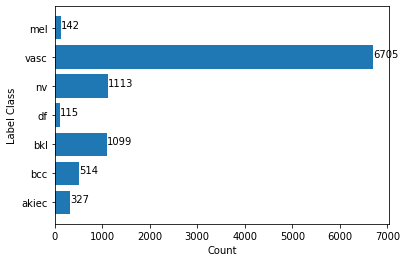

In [13]:
x = classes_df.index
y = classes_df.Count
plt.barh(x, y)
plt.xlabel('Count')
plt.ylabel('Label Class')
for index, value in enumerate(y):
    plt.text(value, index,
             str(value))
plt.show()

#### <span style='font-family:Georgia'> ``Focal Loss - Unbalanced data`` like what I have here can cause some problems to the model learning procedure. To address this  problem, I have used a new loss function named focal loss. ``With the focal loss, we add a modulating factor multiplied  by the Cross-Entropy Loss.`` By this modulating factor, when a sample is misclassified, p is low and modulating factor is  near one, so the loss is unaffected. But as p increases, the modulating factor approaches 0, and the loss for wellclassified examples is down-weighted.



![picture](https://drive.google.com/uc?export=view&id=1nxKtfBV7TGsk7f6pUvXZYQpr7aDlGuFy)

#### <span style='font-family:Georgia'> Get an overview of the images that I would be dealing with by viewing them in a grid divided by classes

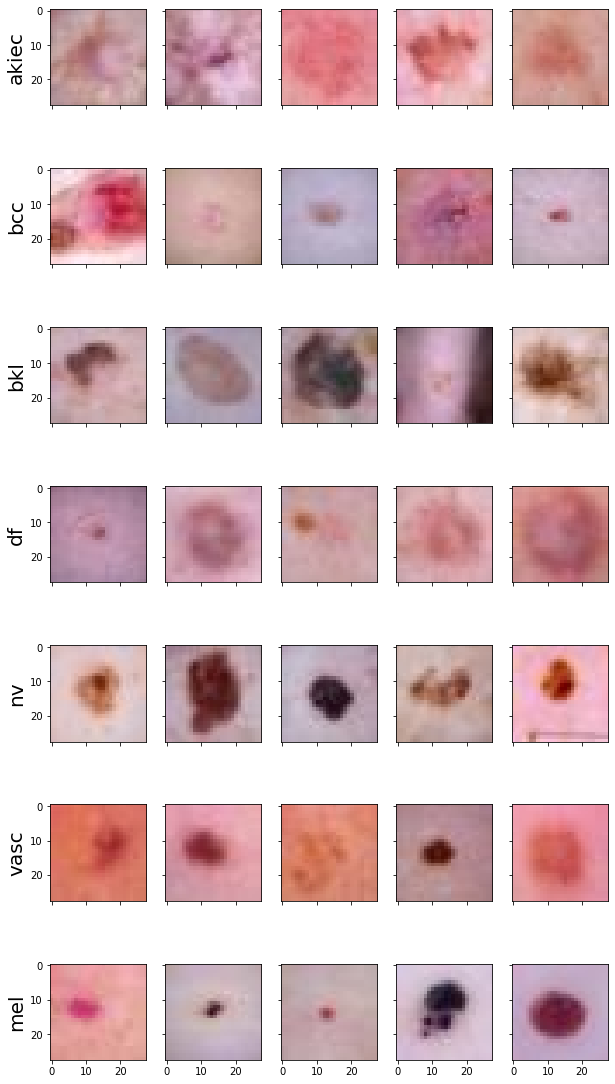

In [14]:
fig, ax = plt.subplots(7, 5)
fig.set_figheight(20)
fig.set_figwidth(10)
for classes in range (7):
  for i, inx in enumerate(np.where(y_train==classes)[0][:5]):
    ax[classes,i].imshow(X_train[inx])
    ax[classes,i].set_ylabel(labels[classes],fontsize = 20.0)
    ax[classes,i].label_outer()

### <span style='font-family:Georgia'> Model Creation & Training

#### <span style='font-family:Georgia'> Sequential model with different types of layers and activation function


In [15]:
model = models.Sequential()

model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28,28,3)))
model.add(layers.Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same' ))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.25))

model.add(layers.Dense(7, activation='softmax'))

#### <span style='font-family:Georgia'> Hyperparameters used to train the model.The model is trained with a low learning rate which will ensure that the model is able to learn optimally by globally setting suitable weights. This will take longer to train but it will produce better results than if the learning rate is high.

In [16]:
batch_size = 128
no_epochs = 300
learn_rate = 0.00013

#### <span style='font-family:Georgia'> Optimizer for the model. Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.

In [17]:
from tensorflow.keras.optimizers import Adam
my_optimizer=Adam(lr=learn_rate)

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### <span style='font-family:Georgia'> Summary of the Model Created

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        4

#### <span style='font-family:Georgia'> Visualize the Model created with layer flow

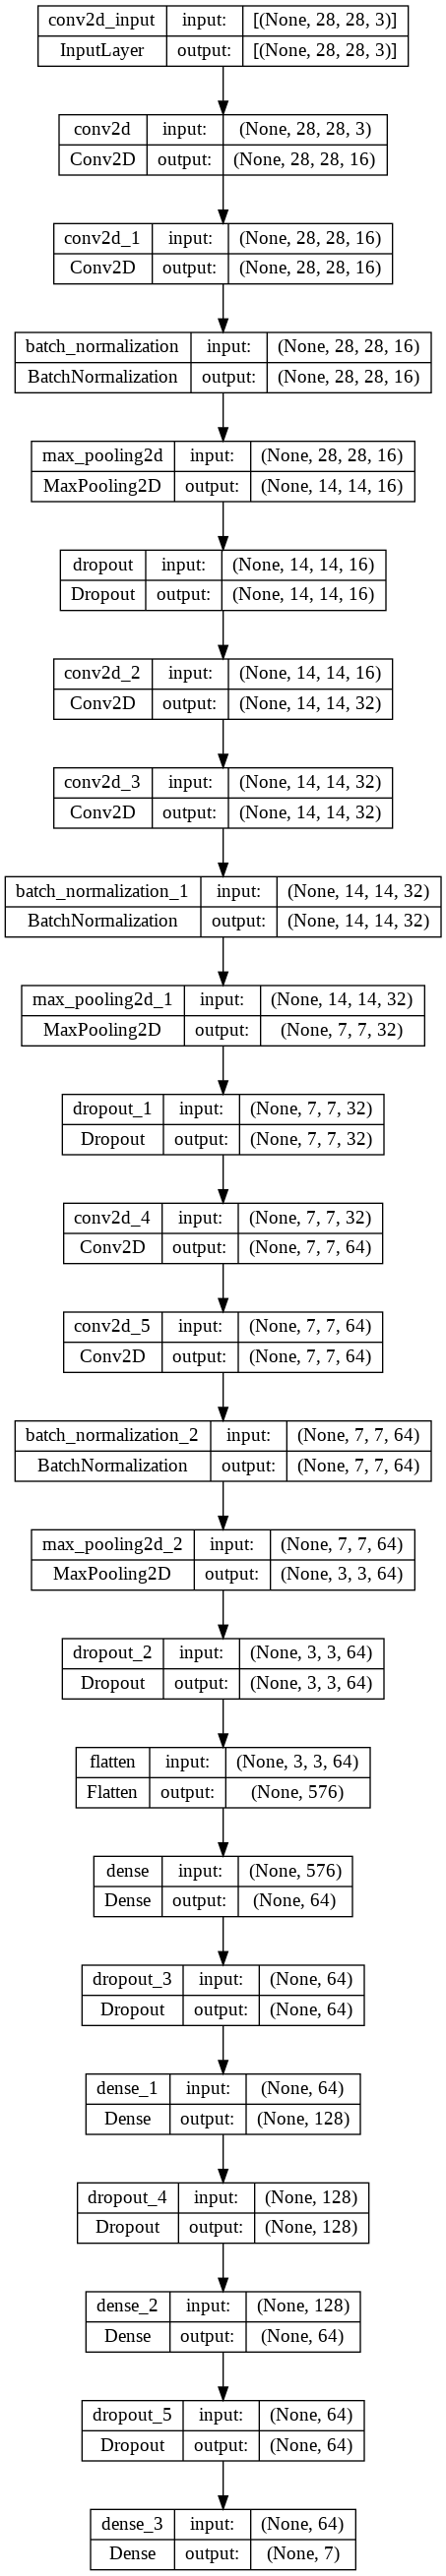

In [19]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#### <span style='font-family:Georgia'> Define a ``class that would be used to stop the model training when we reach a certain rate of validation accuracy``

#### <span style='font-family:Georgia'> ``The model will be trained with an optimum number of epochs to achieve a high accuracy.`` The epochs determine  the number of times the dataset will run through the CNN to train. ``If there are way too many epochs it could  result in overfitting hence it is best to use an optimal number of epochs with early stopping call back function  which will stop the training once the model performance stops improving`` on a hold out validation dataset.

In [20]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point

    def on_epoch_end(self, epoch, logs=None): 
        accuracy = logs["val_accuracy"]
        if accuracy >= self.point:
            self.model.stop_training = True
            
#set the stopping accuracy to 0.78 (which is the highest seen accuracy during training of the model)
callbacks = [StopOnPoint(0.78)] # <- set optimal point

#### <span style='font-family:Georgia'> ``The model performed better with focal loss function which could assist in tackling the issue faced by the  imbalanced dataset.`` Optimizers are functions that are used to modify the attributes such as weights and learning  rate of a neural network. This assists in reducing the overall loss and improves the accuracy. 

#### <span style='font-family:Georgia'> Compile the model with Focal Loss function - gamma = 2

In [21]:
model.compile(loss=SparseCategoricalFocalLoss(gamma=2),
              optimizer=my_optimizer,
              metrics=['accuracy'])

#### <span style='font-family:Georgia'> Fit the model with stopping function defined before

In [22]:
summary = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=no_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[callbacks])

Epoch 1/300
55/55 [==============================] - 15s 29ms/step - loss: 1.1966 - accuracy: 0.4595 - val_loss: 1.2917 - val_accuracy: 0.6690
Epoch 2/300
55/55 [==============================] - 1s 18ms/step - loss: 0.8093 - accuracy: 0.6291 - val_loss: 1.1393 - val_accuracy: 0.6690
Epoch 3/300
55/55 [==============================] - 1s 14ms/step - loss: 0.7277 - accuracy: 0.6426 - val_loss: 0.9863 - val_accuracy: 0.6690
Epoch 4/300
55/55 [==============================] - 1s 15ms/step - loss: 0.7004 - accuracy: 0.6492 - val_loss: 0.8808 - val_accuracy: 0.6690
Epoch 5/300
55/55 [==============================] - 1s 11ms/step - loss: 0.6739 - accuracy: 0.6468 - val_loss: 0.8078 - val_accuracy: 0.6690
Epoch 6/300
55/55 [==============================] - 1s 10ms/step - loss: 0.6486 - accuracy: 0.6474 - val_loss: 0.7930 - val_accuracy: 0.6690
Epoch 7/300
55/55 [==============================] - 1s 9ms/step - loss: 0.6355 - accuracy: 0.6468 - val_loss: 0.7301 - val_accuracy: 0.6670
Epoch 

#### <span style='font-family:Georgia'> Save the model to our drive

In [23]:
tf.keras.models.save_model(model,'SkinSavior_model.hdf5')

#### <span style='font-family:Georgia'> Model Evaluation. Visualize the training vs the validation accuracy of the model

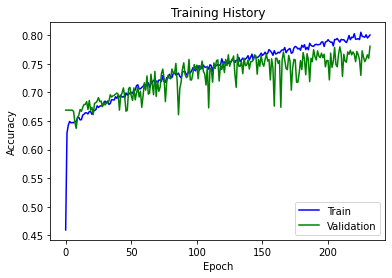

In [24]:
#visualize the training vs the validation accuracy of the model
plt.plot(summary.history['accuracy'], c="b")
plt.plot(summary.history['val_accuracy'], c="g")
plt.title('Training History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [25]:
#check the testing loss and accuracy
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.39188987016677856 / Test accuracy: 0.7775561213493347


#### <span style='font-family:Georgia'> Classification report showing precision, recall and F1 score of all classes with overall accuracy

In [26]:
y_pred = model.predict(X_test)
y_pred_classes = [np.argmax(element) for element in y_pred]
print(classification_report(y_test, y_pred_classes))

63/63 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.51      0.58      0.54        66
           1       0.51      0.46      0.48       103
           2       0.60      0.56      0.58       220
           3       0.38      0.13      0.19        23
           4       0.55      0.33      0.41       223
           5       0.86      0.94      0.89      1341
           6       0.75      0.62      0.68        29

    accuracy                           0.78      2005
   macro avg       0.59      0.52      0.54      2005
weighted avg       0.76      0.78      0.76      2005



#### <span style='font-family:Georgia'> The model was trained rigorously to ensure that I achieved the highest possible accuracy. I used an early  stopping function with a callback to stop model training when the highest possible accuracy had been attained. ``In  a medical data problem, accuracy is not the only important metric that needs to be evaluated.``

#### <span style='font-family:Georgia'> ``The precision and recall of the model is of equal importance, hence I had to ensure that the precision, recall and  F1 score of all classes were not zero. After multiple attempts I achieved an accuracy of 77% with a decent  precision and recall for all classes.``

#### <span style='font-family:Georgia'> Previously, I was not able to get precision and recall more than zero for the classes with less images. After  attempting with focal loss we achieved a better figure. 

### <span style='font-family:Georgia'>Web Application Deployment

In [27]:
#This is the code that will be running in the background of the web app
%%writefile app.py
import streamlit as st
import tensorflow as tf
import streamlit as st
from focal_loss import SparseCategoricalFocalLoss

lesion_type_dict = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions ',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Vascular lesions',
    6: 'Melanoma'
}

@st.cache(allow_output_mutation=True)
def load_model():
  #load the model that we had trained and saved
  model=tf.keras.models.load_model('/content/SkinSavior_model.hdf5', custom_objects={'focal_loss_fixed': SparseCategoricalFocalLoss(gamma=2)})
  return model
with st.spinner('Model is being loaded..'):
  model=load_model()

st.write("""
         # Skin Cancer Classification
         """
         )

#Allow use input of images type jpg and png
file = st.file_uploader("Please upload a skin lesion picture", type=["jpg", "png"])

import cv2
from PIL import Image, ImageOps
import numpy
st.set_option('deprecation.showfileUploaderEncoding', False)
def import_and_predict(image_data, model):
  #take user image and adjust parameters so that the model will accept it as an input
  size = (28,28)    
  image = ImageOps.fit(image_data, size, Image.ANTIALIAS)
  image = numpy.asarray(image)
  img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  img_reshape = img[numpy.newaxis,...]
  #get prediction of the image input
  prediction = model.predict(img_reshape)
  classes_x=numpy.argmax(prediction,axis=1)
  pred = lesion_type_dict[classes_x[0]]
  return pred, prediction
if file is None:
    st.text("Please upload an image file")
else:
    #display the picture and the results of the prediction
    image = Image.open(file)
    st.image(image, use_column_width=True)
    pred, predictions = import_and_predict(image, model)
    score = tf.nn.softmax(predictions[0])
    max_score = (100 * numpy.max(score))
    st.write('This image most likely belongs to the class ', pred, ' with a confidence of ', max_score)

Writing app.py


In [28]:
#establish a connection with ngrok via authentication code
!ngrok authtoken 24YJoEdqFaets62AhKfVdiKt9pX_56D2PZxCfjdRkmexm27kw

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [29]:
#use streamlit to load and run the web app coded previously
!nohup streamlit run app.py &

nohup: appending output to 'nohup.out'


In [30]:
#establish a tunnel with ngrok to run the streamlit app in HTML browser
from pyngrok import ngrok
url=ngrok.connect(port=8501)
url

<NgrokTunnel: "http://0f93-34-142-228-195.ngrok.io" -> "http://localhost:80">

In [ ]:
#configure the port so that the app will be able to run
!streamlit run --server.port 80 app.py >/dev/null

2022-12-02 12:47:01.827102: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
